# Reto del precio del metro cuadrado

In [1]:
import sys
import os
import pickle

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
%config InlineBackend.figure_format = "retina"

## Importamos la base de datos

Utilizamos la base de datos que ya incluye la información de catastro que proporciona el Gobierno de la DCMX (https://sig.cdmx.gob.mx/) y que uniò a la base de precios en el código `Validar acceso a Poligono`.

In [3]:
df = pd.read_csv('./data/reto_precios_cat_lan_lon.csv')

In [6]:
size_df = df.shape
print('Filas: {} ::: Columnas: {}'.format(size_df[1], size_df[0]))

Filas: 40 ::: Columnas: 981


In [7]:
df.columns

Index(['Unnamed: 0', 'main_name', 'subtitle', 'link', 'location', 'price',
       'attributes', 'timestamp', 'id', 'address', 'since', 'description',
       'vendor', 'lat', 'lon', 'price_mod', 'price_currency', 'since_period',
       'since_value', 'days_on_site', 'amenities', 'age_in_years', 'bathrooms',
       'cellars', 'num_floors', 'monthly_fee', 'apartments_per_floor',
       'disposition', 'parking_lots', 'floor_situated', 'orientation',
       'num_bedrooms', 'department_type', 'm2', 'final_price',
       'price_square_meter', 'valor_suelo', 'valor_suelo_num', 'colonia',
       'calle'],
      dtype='object')

Distribución de la variable target `price_square_meter`

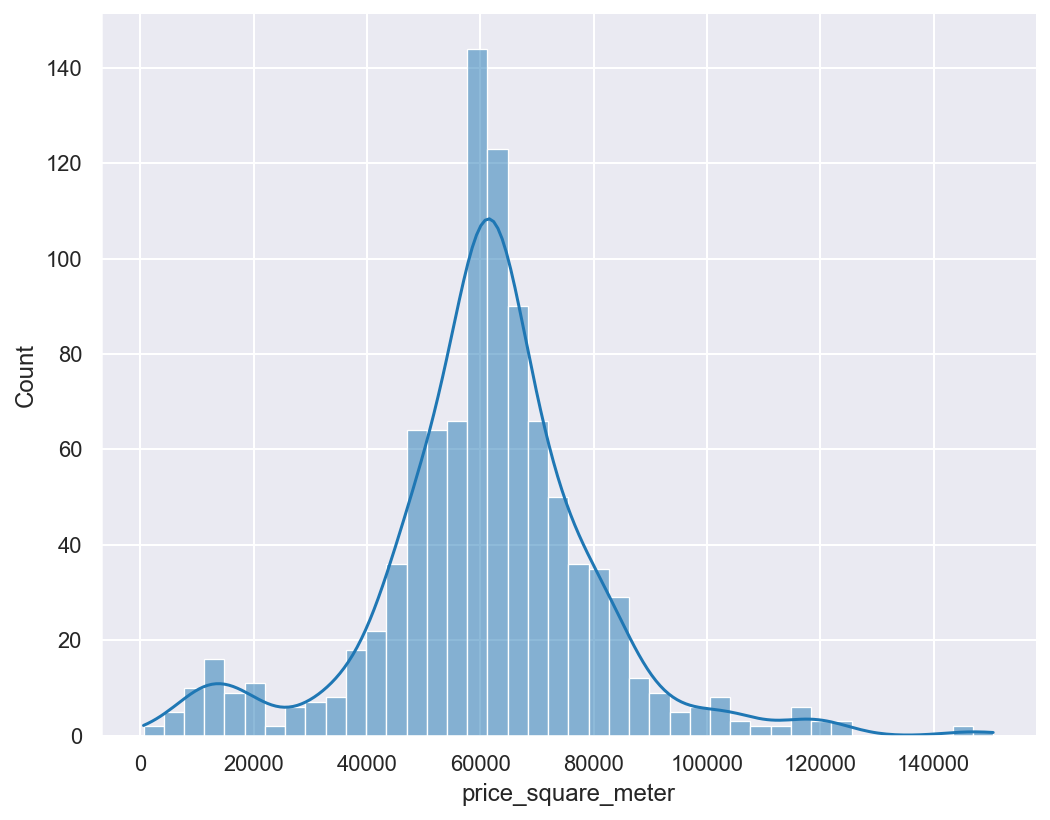

In [8]:
g = sns.displot(df, x='price_square_meter', kde=True, color='tab:blue')
g.fig.set_size_inches(8,6);

## Inspeccionamos que factores influyen en el precio por metro cuadrado

Para esto realizamos un análisis exploratorio de las variables vs `price_square_meter`

In [9]:
import matplotlib.pyplot as plt

De la variable `m2` quitamos valores extermos para que se vea mejor la gráfica

In [10]:
df['m2'].describe()

count     981.000000
mean      111.824608
std       231.604294
min        31.000000
25%        75.000000
50%        93.000000
75%       129.000000
max      7210.000000
Name: m2, dtype: float64

In [11]:
df2 = df[df['m2']<7210]

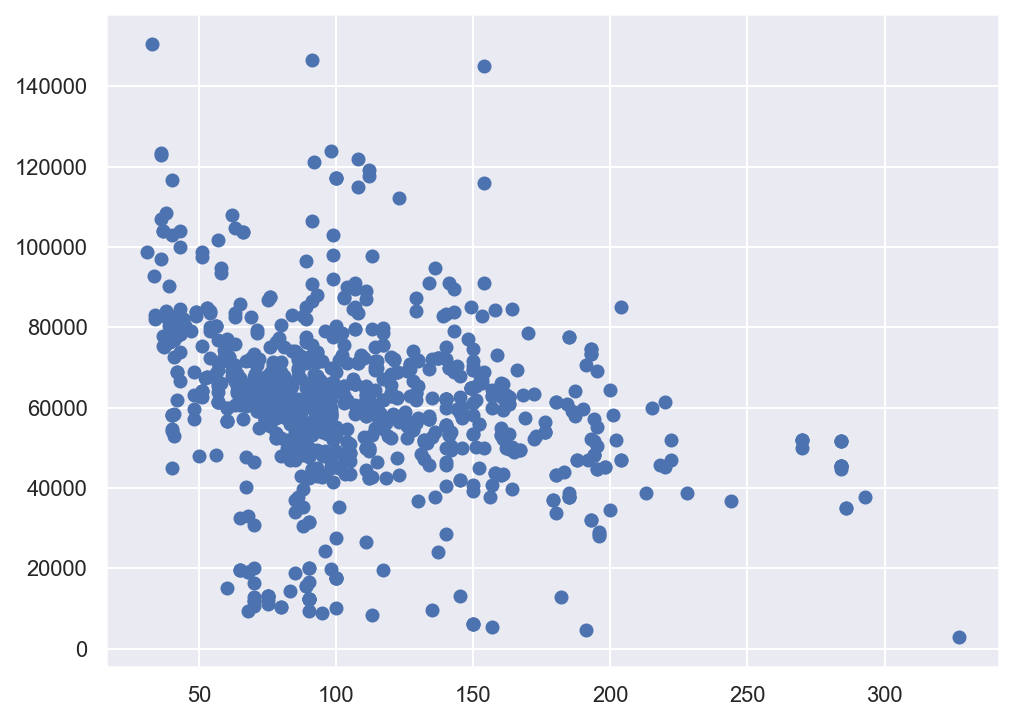

In [12]:
plt.scatter(df2['m2'], df2['price_square_meter']);

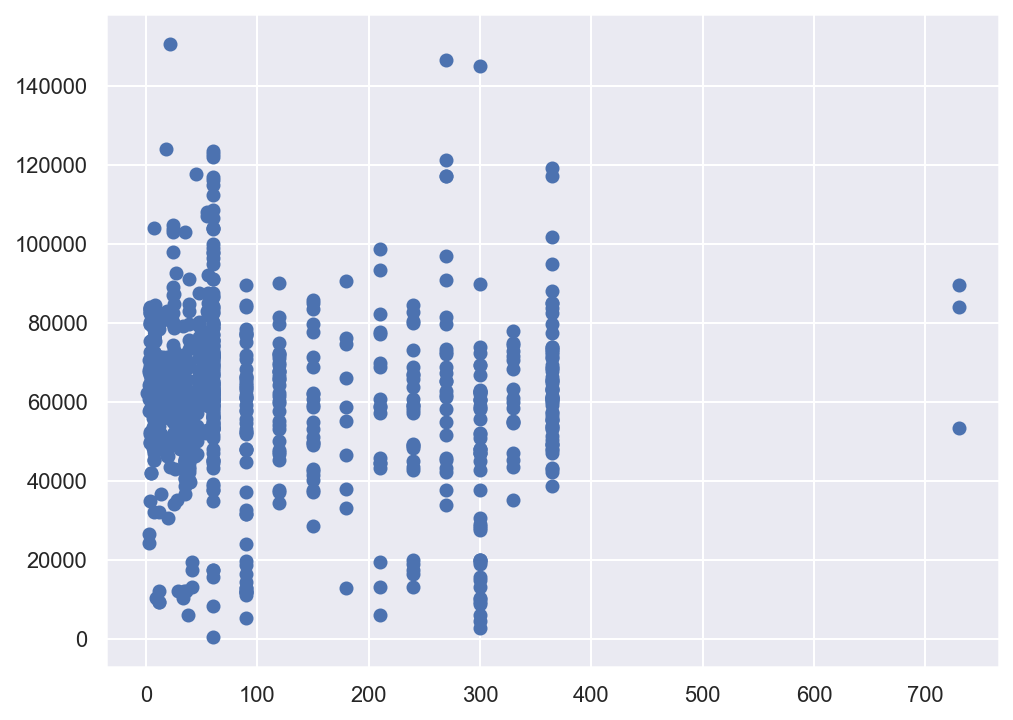

In [13]:
plt.scatter(df['days_on_site'], df['price_square_meter']);

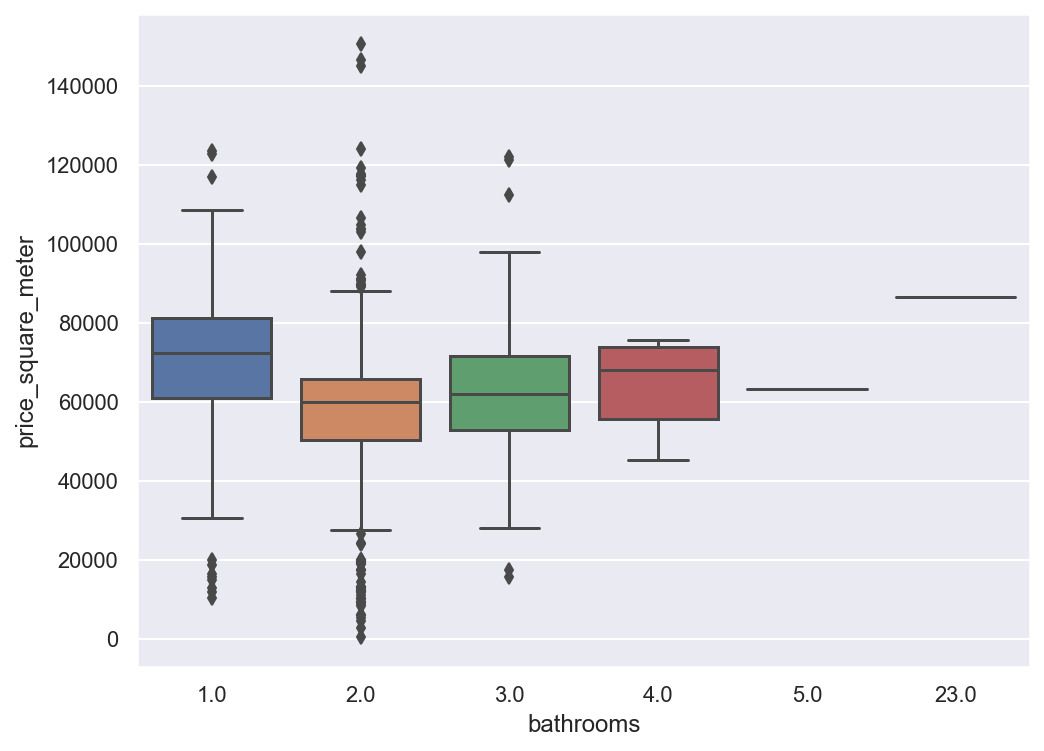

In [14]:
sns.boxplot(x='bathrooms', y='price_square_meter', data=df);

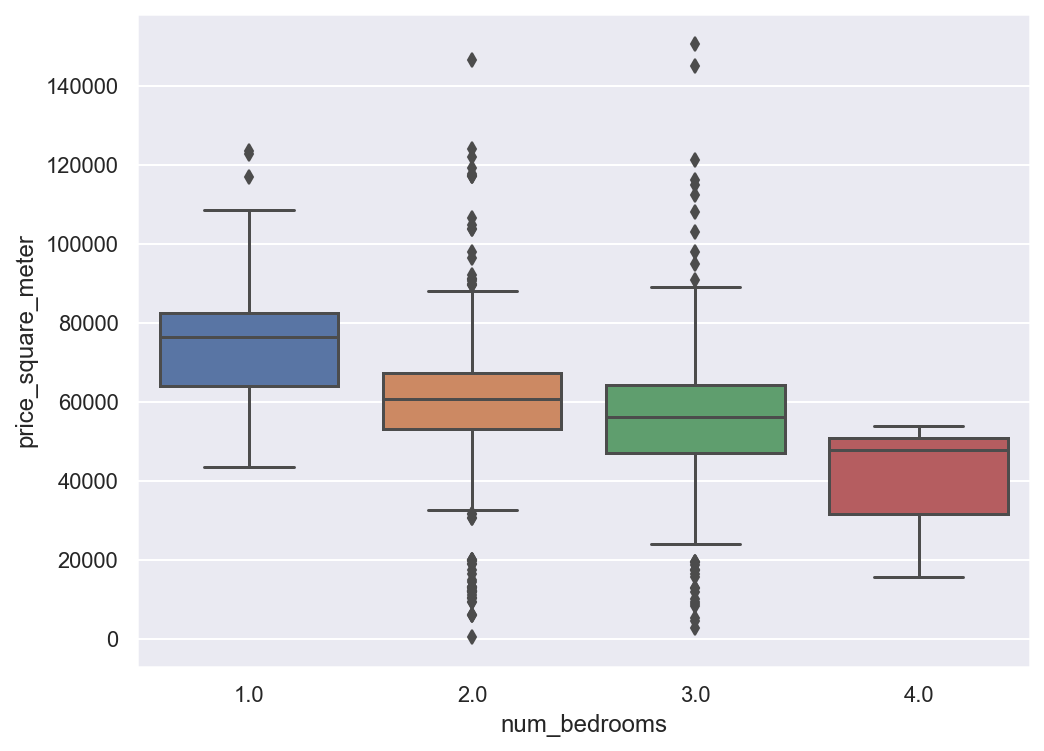

In [15]:
sns.boxplot(x='num_bedrooms', y='price_square_meter', data=df);

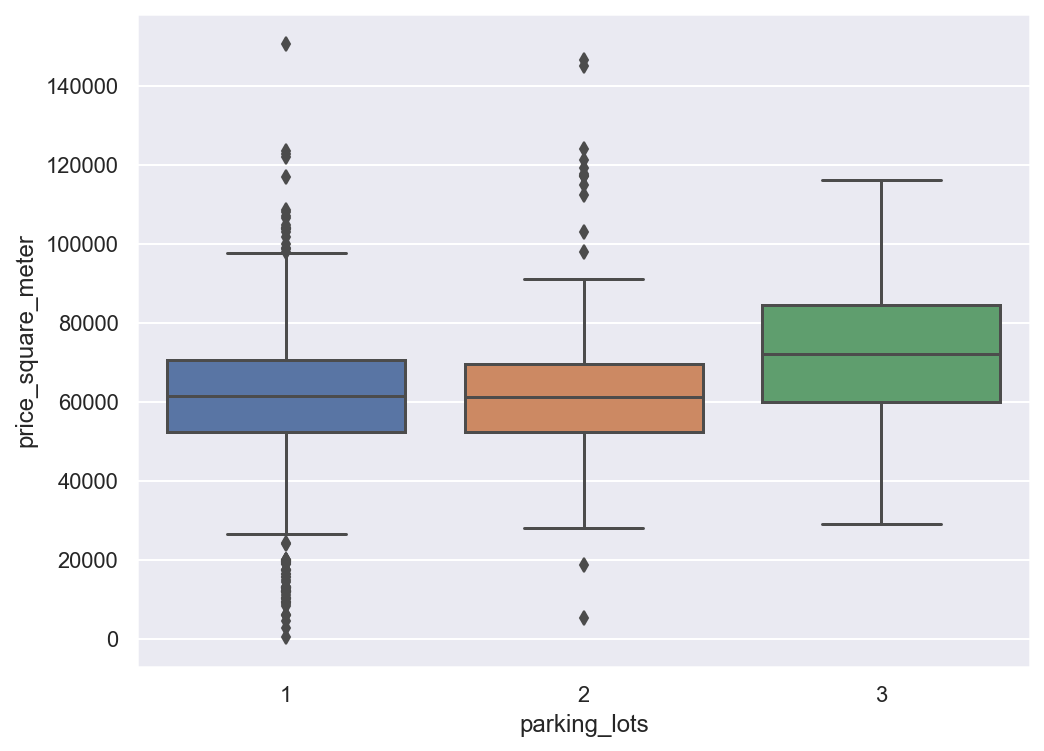

In [16]:
sns.boxplot(x='parking_lots', y='price_square_meter', data=df);

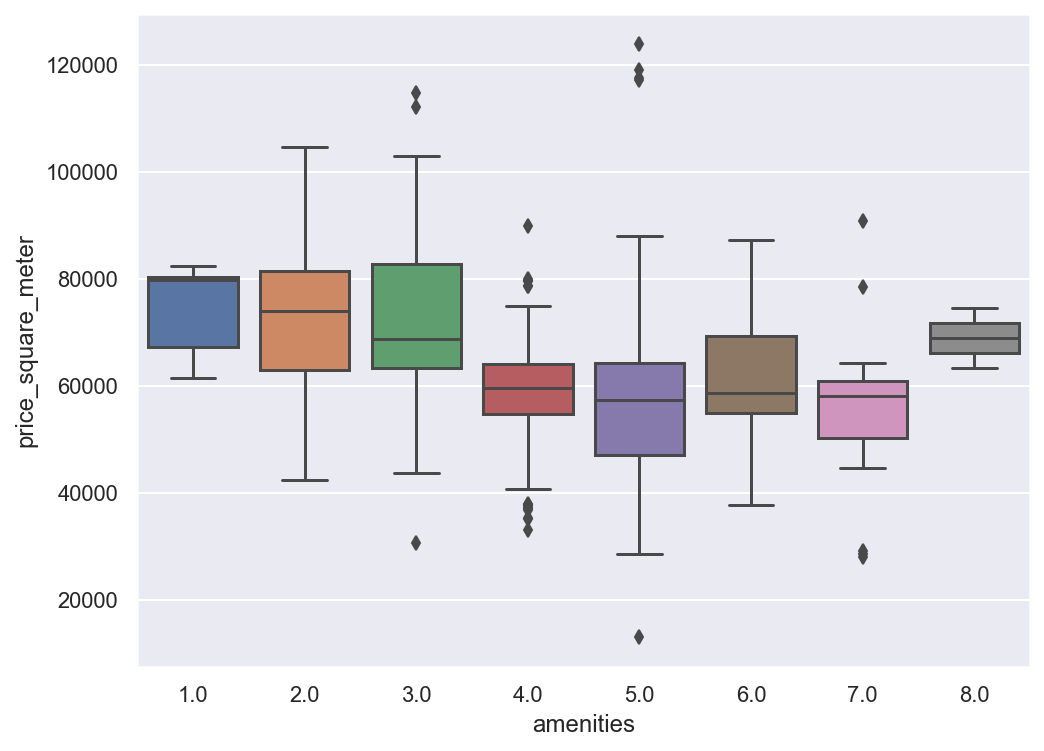

In [17]:
sns.boxplot(x='amenities', y='price_square_meter', data=df);

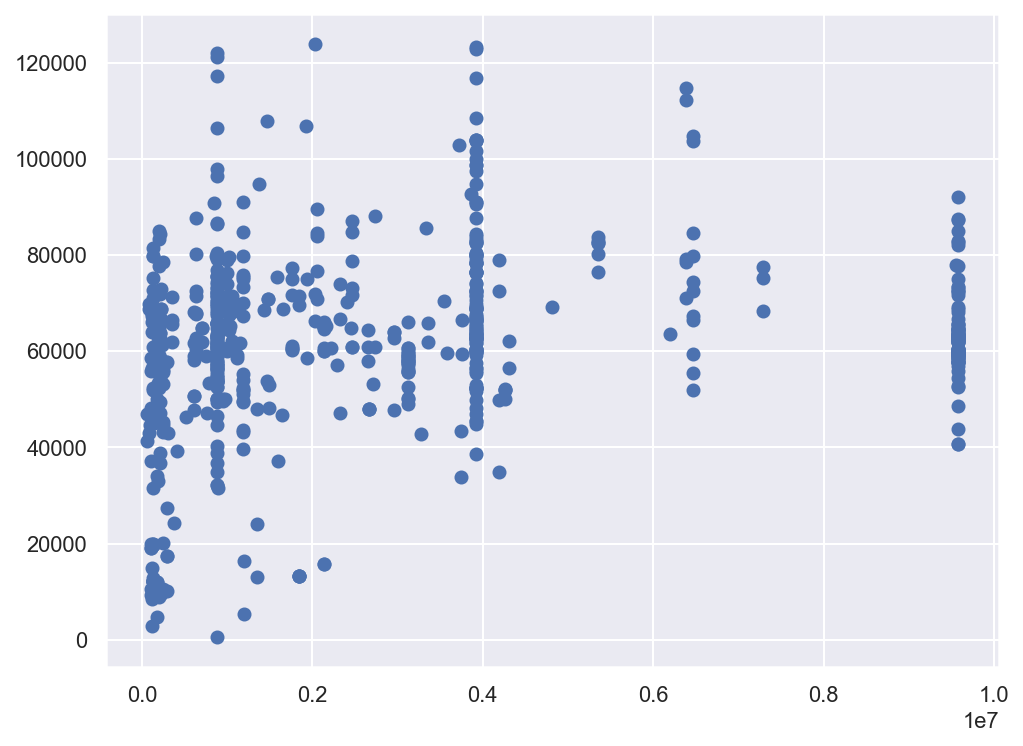

In [18]:
df2 = df[df['valor_suelo_num']<10000000]
plt.scatter(df2['valor_suelo_num'], df2['price_square_meter']);

De la información que obtuvimos de `lat` y `lon` analizamos si podemos usar algo para explicar que factores influyen en el precio del metro cuadrado

In [24]:
df_summ = df.groupby(['colonia'], as_index=False
                     ).agg(cantidad = ('id',np.size), media_precio = ('price_square_meter', np.mean)
                           ).sort_values('media_precio', ascending=False)

df_summ[df_summ['cantidad']>5].head(10)

,colonia,cantidad,media_precio
23,Zona Rosa,23,73571.446125
12,Colonia Roma Norte,315,66424.182845
14,Colonia Tabacalera,17,60521.006817
1,Centro Urbano Benito Juárez,226,59892.258580
13,Colonia Roma Sur,291,59256.019814
4,Colonia Doctores,6,55498.889383
2,Colonia Condesa,10,54929.469344
7,Colonia Hipódromo,10,51634.830385
21,Roma,22,48136.951425
11,Colonia Piedad Narvarte,9,45531.043638


In [23]:
df_summ2 = df.groupby(['calle'], as_index=False
                      ).agg(cantidad = ('id',np.size), media_precio = ('price_square_meter', np.mean)
                            ).sort_values('media_precio', ascending=False)

df_summ2[df_summ2['cantidad']>5].head(10)

,calle,cantidad,media_precio
62,Calle Puebla,13,79928.611693
82,Calle Tonalá,22,73385.847731
28,Calle Colima,124,72036.620114
6,Avenida Insurgentes Sur,13,72005.872963
72,Calle San Luis Potosí,15,70762.374883
24,Calle Chiapas,11,70176.720942
23,Calle Bajío,27,66240.094398
12,Avenida Querétaro,23,66000.426525
3,Avenida Chapultepec,7,64731.526296
95,Ciclovía Monterrey,15,64348.413658


## Generamos un modelo para determinar la influencia de las variables en el precio por metro cuadrado

Tenemos informado 678 registros por el `valor_suelo_num` que se obtiene del catastro del Gobierno de la CDMX, analizaremos la información con esos registros ya que se tiene la hipótesis de que puede ser útil para explicar la variable target `price_square_meter`.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            981 non-null    int64  
 1   main_name             981 non-null    object 
 2   subtitle              981 non-null    object 
 3   link                  981 non-null    object 
 4   location              981 non-null    object 
 5   price                 981 non-null    object 
 6   attributes            981 non-null    object 
 7   timestamp             981 non-null    object 
 8   id                    981 non-null    int64  
 9   address               702 non-null    object 
 10  since                 981 non-null    object 
 11  description           981 non-null    object 
 12  vendor                981 non-null    object 
 13  lat                   981 non-null    float64
 14  lon                   981 non-null    float64
 15  price_mod             9

<div class="alert alert-block alert-warning">
<b>Amenities</b> es una variable con demasiados valores NULOS, por eso la descartamos.
</div>

In [36]:
df2 = df[df['valor_suelo_num'].notnull()]

In [43]:
df2.shape

(678, 40)

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
X = df2[['bathrooms','num_bedrooms','parking_lots','valor_suelo_num']]
y = df2['price_square_meter']

In [69]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

RandomForestRegressor()

In [70]:
rf.feature_importances_

array([0.08257754, 0.20502071, 0.05577444, 0.65662731])

In [63]:
importance = pd.DataFrame({'variable':X.columns, 'importance':rf.feature_importances_})
importance = importance.sort_values('importance', ascending=True)

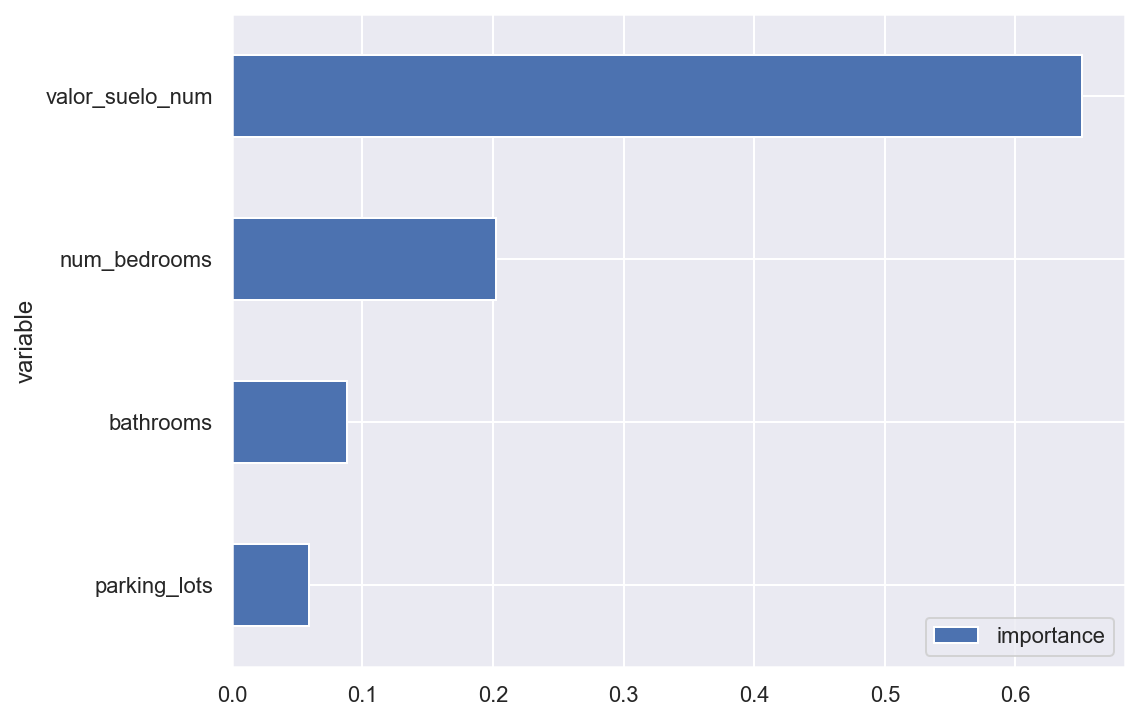

In [64]:
importance.plot.barh(x='variable', y='importance');

### Guardamos resultados

In [71]:
import os
os.chdir('../Functions')
from utils import *

In [72]:
Utilerias.save_load_objects('../DD360/data/importance',importance,'save')

In [73]:
Utilerias.save_load_objects('../DD360/data/df_summ',df_summ,'save')
Utilerias.save_load_objects('../DD360/data/df_summ2',df_summ2,'save')

# Conclusiones

<div class="alert alert-block alert-success">
<b>Conclusiones:</b> Evidentemente el valor del suelo que proviene de la fuente del catastro es una muy buena variable para predecir el precio del metro cuadrado de un inmueble, lo que la hace un factor que influyen en el precio por metro cuadrado, <b>con lo que se resuelve la pregunta 1 del reto</b>. Adicionalmente se puede ver que otras variables tambien son factores, como:

- num_bedrooms
- bathrooms
- parking_lots
    
Las calles donde se encuentran los inmuebles de mayor precio y que haya mas de 5 inmuebles en ellas son:
- Calle Puebla
- Calle Tonalá
- Calle Colima
- Avenida Insurgentes Sur
- Calle San Luis Potosí
- Calle Chiapas
- Calle Bajío
- Avenida Querétaro
- Avenida Chapultepec
- Ciclovía Monterrey
    
</div>